# **Salifort Motors: Providing data-driven suggestions for HR**

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

The goal of this project is to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If we can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

## Step 1. Imports

In [221]:
# Import packages

# for data manipulation
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for displaying all the columns in dataframes
pd.set_option('display.max_columns', None)

from sklearn.linear_model import LogisticRegression

# for metrics and helpful functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [149]:
# Import raw data and save as an intial dataframe, df0
df0 = pd.read_csv("HR_capstone_dataset.csv")

## Step 2. Data Cleaning + Exploratory Data Analysis

### Gather basic information about the data

In [101]:
# Gather basic information about the data
df0.info()
df0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Familiarize yourself with the HR dataset

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)?

### Rename columns

Standardizing the column names so that they are all in `snake_case`. Also changing the name of time_spend_company to tenure and correcting a typo for 'average_montly_hours'

In [151]:
# Rename columns
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

# check all column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

In [105]:
# Check for missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [107]:
# Check for duplicates
df0.duplicated().sum()

3008

3,008 rows contain duplicates. That's about 20% of the data. 

In [109]:
# Inspecting some of the duplicate rows
df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


It seems implausible for two employees to self-report duplicate data in a survey. Therefore, it's likely not an issue to remove these columns.

In [153]:
# Drop duplicates and save resulting dataframe in a new variable, df1
df1 = df0.drop_duplicates(keep='first')

### Check outliers

Check for outliers in the data.

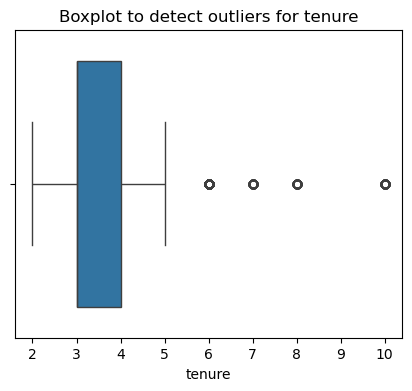

In [113]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize = (5,4))
plt.title('Boxplot to detect outliers for tenure')
sns.boxplot(x=df1['tenure'])
plt.show()

The above boxplot shows that there are significant outliers in `tenure`.

It would be helpful to check how many rows in this column contain outliers. To determine the number of outliers, need to find the number of values that fall outside the upper and lower limits for non-outliers in `tenure`.

In [115]:
# Determine the number of rows containing outliers

# interquartile range
percentile75 = df1['tenure'].quantile(0.75)
percentile25 = df1['tenure'].quantile(0.25)
iqr = percentile75 - percentile25

# define upper and lower limits for non-outliers in 'tenure'
upper_limit = percentile75 + 1.5*iqr
lower_limit = percentile25 - 1.5*iqr
print('Lower limit: ',lower_limit)
print('Upper limit: ',upper_limit)

# determine outliers values (outside of upper and lower limits)
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

# count how many rows in 'tenure' are outliers
print("Number of rows in 'tenure' that are outliers: ",len(outliers))

Lower limit:  1.5
Upper limit:  5.5
Number of rows in 'tenure' that are outliers:  824


It may be prudent to remove these outliers in the model-building stage!

It would be interesting to know how many employees left and what percentage of all employees this figure represents. This can be checked by counting the number of entries in the 'left' column with a value of 1. Checking the number of employees that left and the proportion of total employees that left.

In [117]:
# Get numbers of people who left vs. stayed
print(df1['left'].value_counts())

# Get percentages of people who left vs. stayed
df1['left'].value_counts(normalize=True)

left
0    10000
1     1991
Name: count, dtype: int64


left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

### Data visualizations

Starting with a stacked boxplot of `average_monthly_numbers` for `number_project`. These variables can be used to compare the distrubutions of employees who left versus those who stayed.

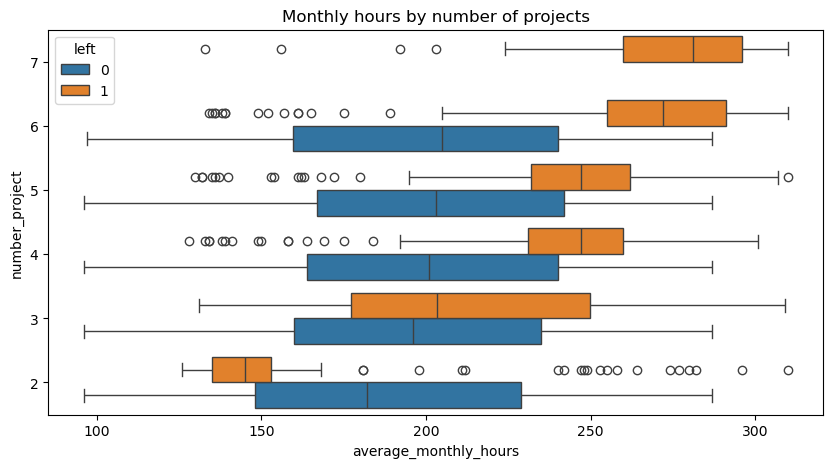

In [119]:
# stacked boxplot of 'average_monthly_numbers' for 'number_project'
plt.figure(figsize=(10,5))
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient='h').invert_yaxis()
plt.title('Monthly hours by number of projects')
plt.show()

In order to contextualize these distributions with sample sizes, you can plot stacked histograms to show what proportions of `number_hours` and `average_monthly_hours` stayed versus left the company.

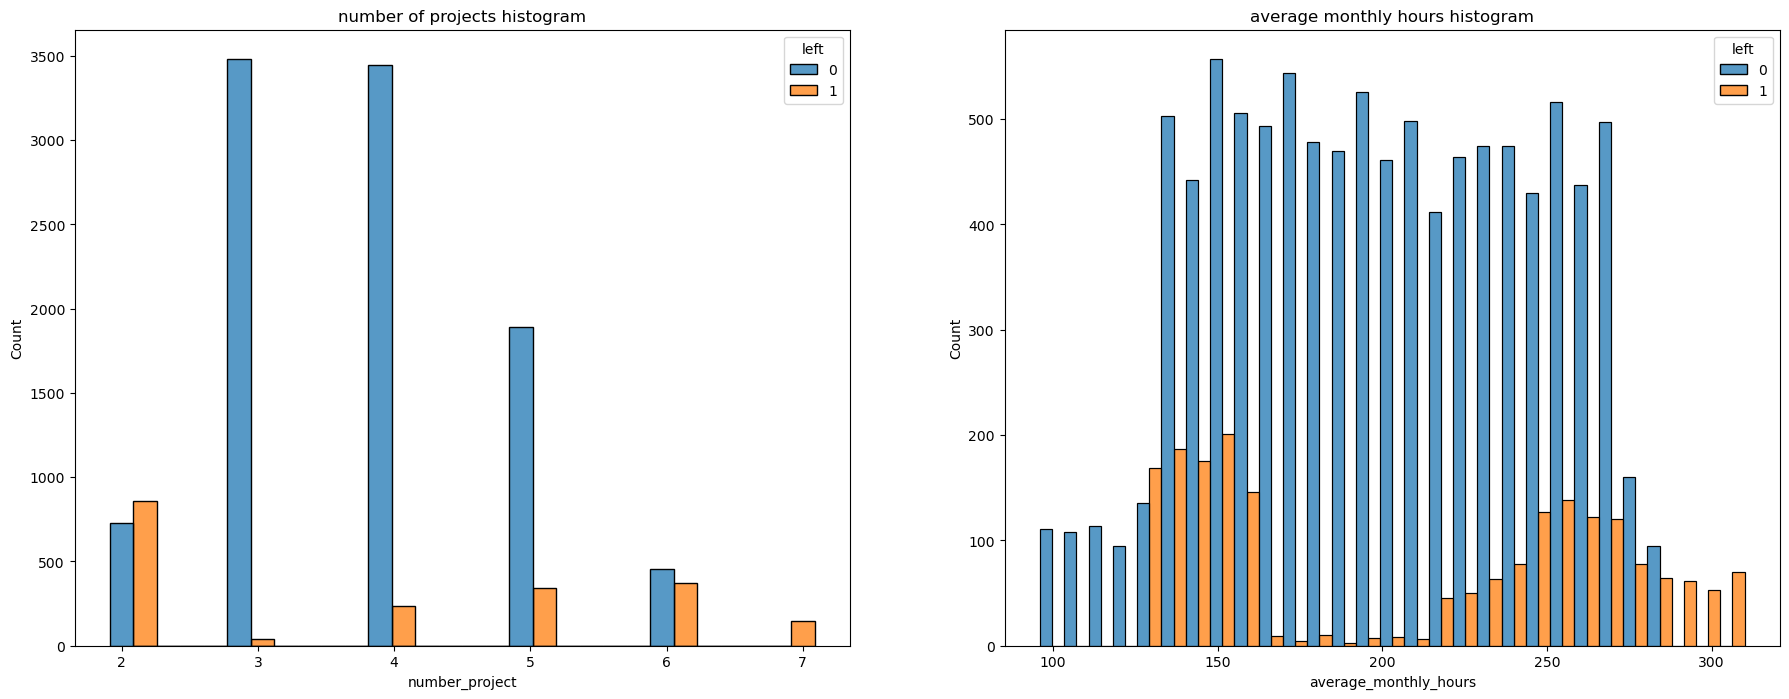

In [30]:
# stayed vs left histograms for 'number_project' and 'average_monthly_hours'
fig, ax = plt.subplots(1,2, figsize=(22,8))
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[0])
ax[0].set_title('number of projects histogram')
sns.histplot(data=df1, x='average_monthly_hours', hue='left', multiple='dodge', ax=ax[1])
ax[1].set_title('average monthly hours histogram')
plt.show()

It could be natural to assume that employees that work on the greatest number of projects would also work the most hours; and this is confirmed by the stacked boxplots. Some other notable details:

1. It looks like there are two groups of employees that left the company. First is those who worked on relatively fewer projects and fewer hours than their colleagues. And second, is those who worked on the most number of projects/hours. It seems reasonable to assume that Group B represents employees that felt overworked and may have left as a result. For Group A, it's possible that these employees left due to dismissal or were planning on quitting.

2. Every employee that worked on 7 projects left the company. The interquartile ranges of this group and the group who left while working on 6 projects is ~255-295 hours/month - which is higher than any other group.

3. 3-4 projects seems to be the optimal range for most employees. These groups have very small ratios of left/stayed employees.

4. Assuming a 40 hour work week with 2 weeks of vacation per year, the average number of hours per month is given by `50 weeks * 40 hours per week / 12 months = 166.67 hours per month`. This means that aside from employees working on 2 projects, even employees who stayed tended to work considerably above average hours per month. There may be a larger issue of employees being overworked.

In [121]:
# confirming that all employees who worked 7 projects left the company
df1[df1['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

Next, let's examine the average monthly hours versus employee satisfaction levels, comparing employees that stayed versus those who left.

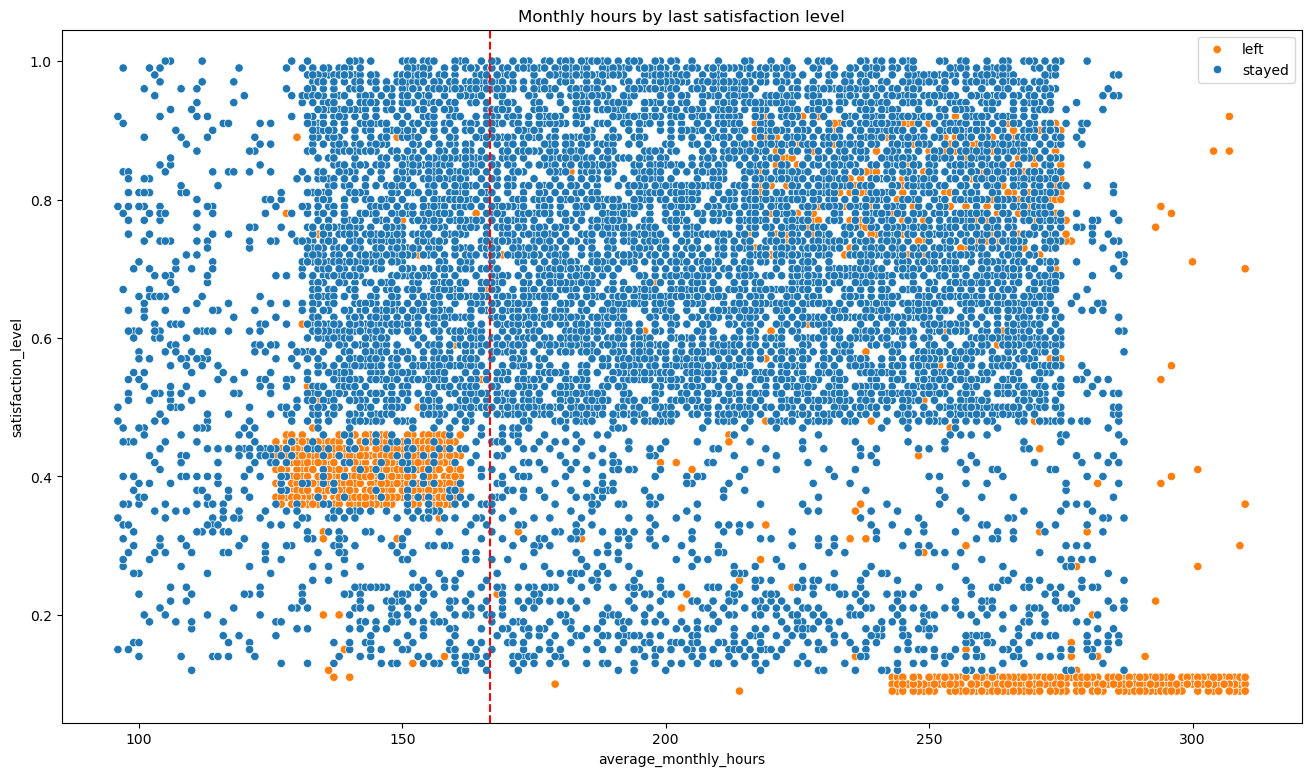

In [123]:
# creating a scatterplot of 'average monthly hours' versus 'satisfaction level'
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left')
plt.axvline(x=166.67, color='r', label='166.67 hrs/mo', ls='--') # adding a vertical line representing assumed average monthly work hours
plt.legend(labels=['left','stayed'])
plt.title('Monthly hours by last satisfaction level')
plt.show()

From the bottom right quadrant of the above scatterplot, there's a decent number of employees (which largely left the company) that seemed to work ~240-320 hours per month. At the higher end, this is approaching 80 hour work weeks. It's very likely that their very low satisfaction levels are linked to this. 

The other notable group of employees that left the company is in the bottom left quadrant of the above plot. These employees also reported relatively low satisfaction levels but worked below average numbers of hours. It's more difficult to speculate as to why these employees left the company. 

For the next visualization, it may be useful to visualize satisfaction levels by tenure. I'll use a combination of stacked boxplots and histograms, as before.

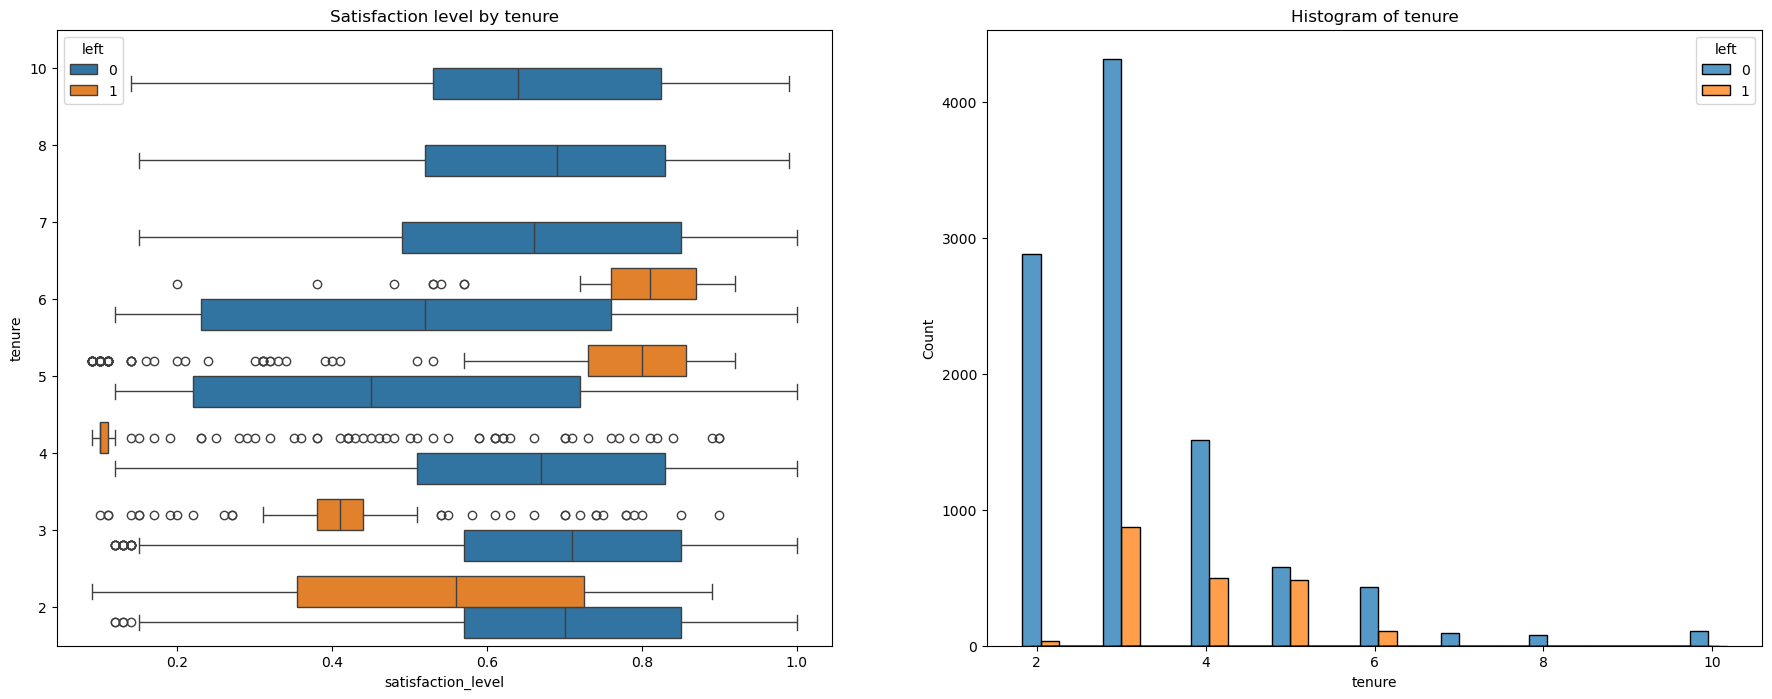

In [125]:
# boxplot showing distribution of 'satisfaction level' by 'tenure', comparing employees that stayed versus those who left
fig, ax = plt.subplots(1,2, figsize=(22,8))
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient='h', ax=ax[0]).invert_yaxis()
ax[0].set_title('Satisfaction level by tenure')

#histogram showing distribution of 'tenure', comparing employees that stayed versus those who left
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Histogram of tenure')
plt.show()

Some observations from the above plots:

1. Employees who left generally fall into two categories. First is those with generally low satisfaction levels and tenure. The second group are those with very high satisfaction levels and medium-length tenure.
2. Employees with 4 years at the company that left reported unusually low satisfaction levels. It's worth further investigating whether any company-wide changes occured 4 years ago that may explain this trend.
3. The long-tenured employees tend not to leave the company, which makes intuitive sense.
4. There are far fewer long-tenured employees than otherwise. This also seems natural as these could represent the highest-ranking and highest paid employees.

We can examine this by visualizing salary levels for different lengths of tenure. To account for sample size discrepancies between short-tenured and long-tenured employees, we can isolate these groups for this visualization. Previous histograms show that the employee counts begin to fall significantly at a tenure of around 7 years, so we'll use this value as a threshold. 

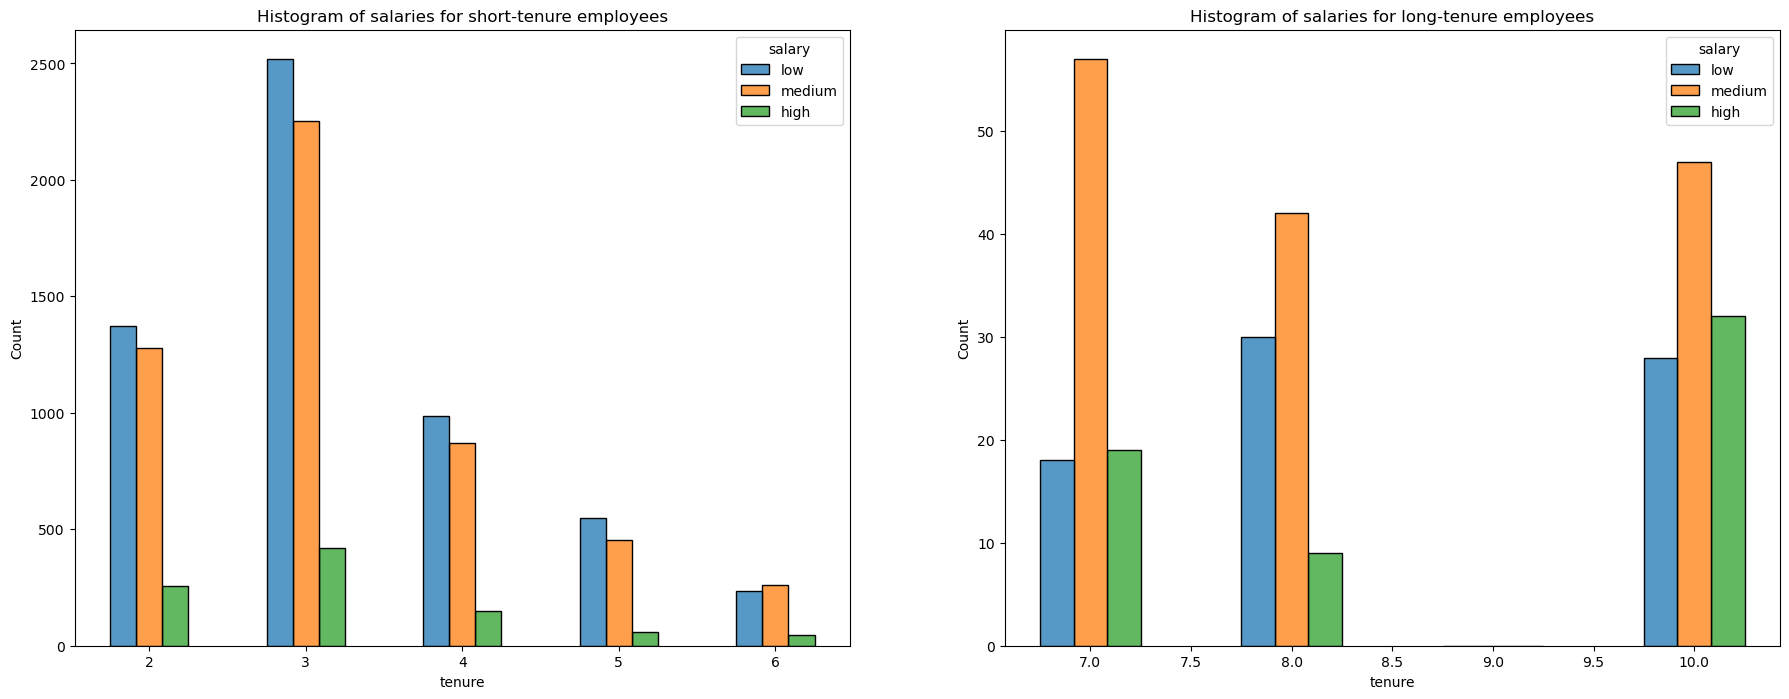

In [127]:
# Salary level histogram by tenure; divide employees into 'long-tenured' and 'short-tenured' subgroups
fig, ax = plt.subplots(1,2, figsize=(22,8))

# define short-tenured employees as those with less than 7 years at the company
short_tenure = df1[df1['tenure'] < 7]

# define long-tenured employees as those with more than 7 or more years at the company
long_tenure = df1[df1['tenure'] >= 7] 

# short tenured employee histogram
sns.histplot(data=short_tenure, x='tenure', hue='salary', discrete=1, hue_order = ['low','medium','high'], multiple='dodge', shrink=0.5, ax=ax[0])
ax[0].set_title('Histogram of salaries for short-tenure employees') 

# long tenured employee histogram
sns.histplot(data=long_tenure, x='tenure', hue='salary', discrete=1, hue_order = ['low','medium','high'], multiple = 'dodge', shrink=0.5, ax=ax[1])
ax[1].set_title('Histogram of salaries for long-tenure employees')
plt.show()

1. Low tenure employees up to 5 years follow a clear salary distribution pattern in which most employees are low-salary, followed by medium-salary, and fewest are high-salary. High-salary employees are clearly under-represented in the low-tenure subgroup. 
2. The same pattern of salary distribution is not seen in high tenure employees. In this group, medium-salaried employees make up the largest proportion of each year's cohort past year 7.
3. Confirmed that high-salaried employees are not over-represented amongst their long-tenured peers.

In a previous visualization, we explored the correlation between working hours and satisfaction levels. It would be interesting to see the correlation between working hours and evaluation scores next.

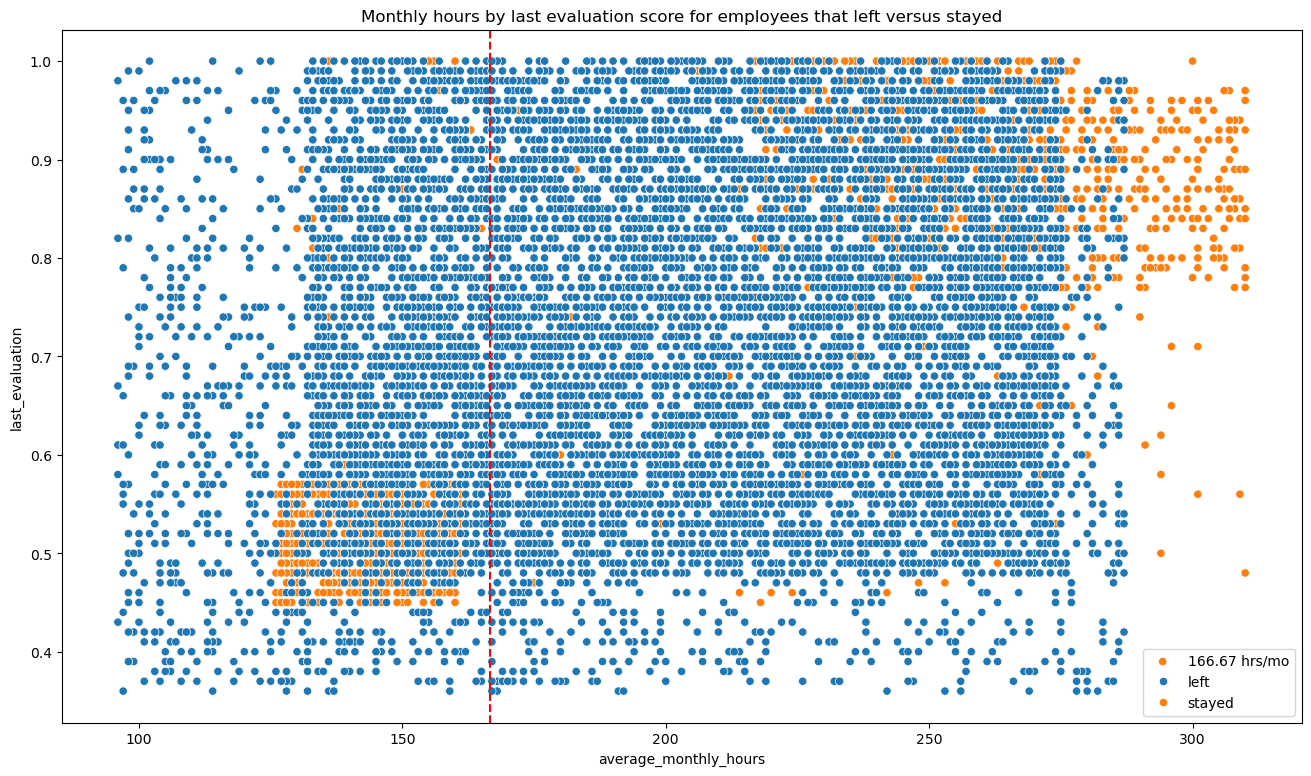

In [129]:
# scatterplot of 'average monthly hours' and 'last evaluation'
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left')

# including the previously calculated assumed average monthly hours
plt.axvline(x=166.67, color='r', label='166.67 hrs/mo', ls='--')
plt.legend(labels=['166.67 hrs/mo','left','stayed'])
plt.title('Monthly hours by last evaluation score for employees that left versus stayed')
plt.show()

From the above scatterplot: 

1. There are two notable groups of employees that left. The first group, in the top right quadrant, represents employees that had well above average working hours and who scored very highly on evaluations. The second group, in the bottom left quadrant, represents employees that had below-average working hours and scored poorly on evaluations.
2. Most data points are to the right of the average, indicating that most employees in this company work well over 167 hours per month.
3. The data points in the upper left and bottom right quadrants are notably sparse - in other words, there seems to be a correlation between working hours and evaluation score. Although there are instances of low-working-hour emplployees being evaluated highly and high-working-hour employees being evaluated poorly.

It would be interesting to see whether working hours are correlated with promotions in the last five years.

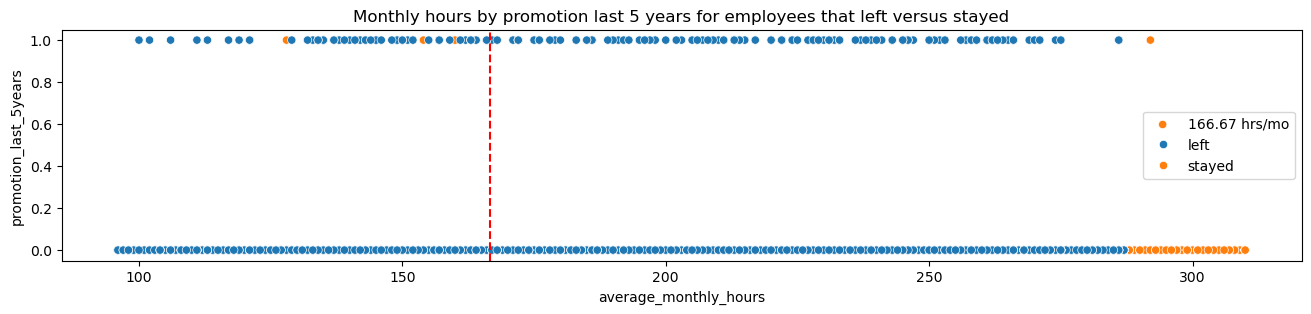

In [131]:
# scatterplot of 'average_monthly_hours' and 'promotion_last_5years'
plt.figure(figsize=(16,3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left')

# including line of assumed average monthly hours
plt.axvline(x=166.67, label='166.67 hrs/mo', color='r', ls='--')

plt.legend(labels=['166.67 hrs/mo','left','stayed'])
plt.title('Monthly hours by promotion last 5 years for employees that left versus stayed')
plt.show()

From the above scatterplot:

1. Very few employees that were promoted in the last five years left the company.
2. Very few employees that worked the most hours got promoted in the last five years.
3. Almost all employees that left were working the longest average monthly hours.

Lastly, we can investigate how employees who left are distributed among different departments. We'll use stacked histograms to compare these counts by department.

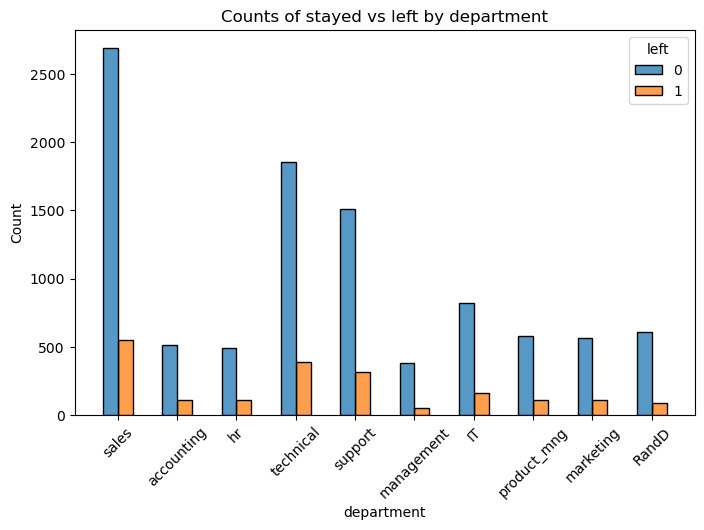

In [133]:
# histogram of employees that left versus stayed by department
plt.figure(figsize=(8,5))
sns.histplot(data=df1, x='department', hue='left', discrete=1, hue_order = [0,1], multiple='dodge', shrink=0.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed vs left by department')
plt.show()

There does not seem to be any department that differs significantly in its proportion of employees who left versus those who stayed.

### Insights

We have established a connection between employees leaving and poor working conditions. Leaving was shown to be tied to above-average working hours being the norm, too many projects, and lack of promotions. These employees were also shown to be connected to generally lower satisfaction levels and evaluation scores. There seems to be a large degree of burnout but at the same time, if employees spend 7 or more years at the company, they are unlikely to leave.

In the next section we'll construct and evaluate a logistic regression model to further investigate these findings. Because our goal is to predict whether or not an employee will leave the company, a binomial regression model is well suited to this binary classification task.

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size





## Step 3. Model Building

### Logistic Regression

Before splitting the data, we must encode the non-numeric fields: `department` and `salary`. \
Since `department` is a categorical variable, it can be a dummy variable for the model. \
For the `salary` variable, we will convert into numerical values between 0-2 to represent the three salary levels.

Since logistic regression is sensitive to outliers, at this stage we can create a new dataframe which excludes the known outliers for `tenure`. Finally, the outcome variable is defined as 'left' and all other variables are defined as features for the model.

In [198]:
# encoded dataframe copied from original
df_enc = df1.copy()

# encoding salary variable as a numeric
df_enc['salary'] = (df_enc['salary'].astype('category').cat.set_categories(['low','medium','high']).cat.codes)

# encoding department as a dummy variable
df_enc = pd.get_dummies(df_enc, drop_first=False)

# creating a new dataframe for modeling, excluding outlier rows: df_logreg
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

# isolating the model's outcome variable: y
y = df_logreg['left']

# we want to use all variables other than 'left' as features in the model: X
X = df_logreg.drop('left', axis=1) 

# splitting the data into a training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# constructing a logistic regression model and fitting it to the training dataset
logreg_model = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

# using the regression model to make predictions on the test set
y_predictions = logreg_model.predict(X_test)

## Step 4. Results and Evaluation

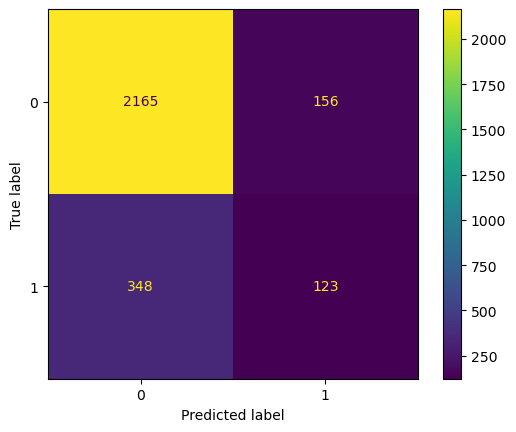

In [215]:
# creating a confusion matrix to visualize the results of the model
log_confusionmatrix = confusion_matrix(y_test, y_predictions, labels = logreg_model.classes_)
matrix_display = ConfusionMatrixDisplay(confusion_matrix=log_confusionmatrix, display_labels= logreg_model.classes_)
matrix_display.plot(values_format='')
plt.show()

The upper-left quadrant displays the number of true negatives. The upper-right quadrant displays the number of false positives. The bottom-left quadrant displays the number of false negatives. The bottom-right quadrant displays the numbr of true positives. We can see from the above plot that the model returned mostly true negatives and true positives but we will create a classification report with various evaluation metrics.

## Model evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






In [210]:
# classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_predictions, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



### Summary of model results

The above report shows that the logistic regression model achieved a precision of 79%, a recall of 82%, f1 score of 80% (weighted averages), along with an accuracy of 82%. Important to note that the scores are significantly lower for 'Predicted would leave'. 

### Conclusion, Recommendations, Next Steps

The data exploration and model support the hypothesis that the employees at this company are overworked. 

To retain employees, the following recommendations may be presented to stakeholders:

* Cap the number of projects an employee can work on. The optimal workload seems to be 3-4 projects.
* Consider promoting more employees that have been at the company for 4 or more years, or further investigate the disproprtionatly high dissatisfaction expressed by 4 year employees.
* High evaluation scores should not be reserved for employees working 200+ hours per month. Consider a proportionate scale for assessing and rewarding employee contributions.

**Next Steps** 

It may be useful to check the frequency of employee evaluations, if possible. If the evaluations are not performed regularly, they may be lagging indicators of performance and it may be worthwhile to predict employee retention without this feature. It's also possible that an employee's evaluation score directly influences whether or not they leave. 
For another project, a k-means model could be applied to this data for cluster analysis or a decision-tree model could be tried to see how the results compare.